<a href="https://colab.research.google.com/github/zimine/Twitter-Text-Analysis/blob/main/twitter_text_analysis_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load packages

In [1]:
!pip install tweet-preprocessor
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=4cda8b365a89fcd9acc3930b6f812f2b659f4a53ced31623c74a496c60877b9c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [14]:
import logging
import wget
import os
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import preprocessor as p
import seaborn as sns
%matplotlib inline

## 2. Download dataset

In [3]:
print('Downloading dataset...')

# The URL for the dataset zip file
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'

# Download the file 
wget.download(url)

# Unzip the dataset
!unzip trainingandtestdata.zip

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


# 3. EDA

In [4]:
# load the data into dataframe
df = pd.read_csv("./training.1600000.processed.noemoticon.csv", 
     names=['label', 'twitter_id', 'time', 'query', 'account', 'tweet'],
     encoding='latin-1')

# print the number of tweets
print('Number of tweets: {:,}\n'.format(df.shape[0]))

# sample 10 records from the data
df.sample(10)

Number of tweets: 1,600,000



,label,twitter_id,time,query,account,tweet
491382,0,2183809387,Mon Jun 15 15:00:54 PDT 2009,NO_QUERY,lushlady15,@LetsKissnMakeup which video?
1238604,4,1993330844,Mon Jun 01 10:12:18 PDT 2009,NO_QUERY,Bearskopff,@richard4481 What is it?
1244946,4,1994953750,Mon Jun 01 12:43:14 PDT 2009,NO_QUERY,keeto,@alex_gibson Thanks.
1243111,4,1994476990,Mon Jun 01 11:58:55 PDT 2009,NO_QUERY,klee15,@JohnFClark yay for John and Phyllis!
1008336,4,1880791071,Fri May 22 02:31:02 PDT 2009,NO_QUERY,blueyedgrl89,Just got down my first song singing and playin...
586219,0,2215892148,Wed Jun 17 18:45:18 PDT 2009,NO_QUERY,LiaDavis7,they didnt have any bottlecaps
387493,0,2054025452,Sat Jun 06 06:21:47 PDT 2009,NO_QUERY,putitaway,My 9 year old nephew just emailed me asking 2 ...
1584326,4,2190547994,Tue Jun 16 03:02:38 PDT 2009,NO_QUERY,dilipm,yay! thursday travel to delhi postponed to nex...
1368645,4,2050640928,Fri Jun 05 19:02:06 PDT 2009,NO_QUERY,ChampionPhts,@dantelewis wish my inbox was full of dante le...
679854,0,2249342199,Fri Jun 19 22:09:11 PDT 2009,NO_QUERY,Stoptouching,@QuaniG nahh no job 4 me abercrombie where? t...


In [5]:
# number of unique id
print(df['twitter_id'].nunique())

# number of unique account
print(df['account'].nunique())

1598315
659775


In [7]:
# split the date column into week, month, day, time, timezone, year
df[['week','month','day','time','timezone','year']] = df['time'].str.split(" ", expand=True)

# check if time is normalized (if the timezone is the same)
df['timezone'].nunique()

1

In [ ]:
df

,label,twitter_id,date,query,account,tweet,week,month,day,time,timezone,year
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Mon,Apr,06,22:19:45,PDT,2009
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Mon,Apr,06,22:19:49,PDT,2009
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Mon,Apr,06,22:19:53,PDT,2009
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Mon,Apr,06,22:19:57,PDT,2009
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Mon,Apr,06,22:19:57,PDT,2009
...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,Tue,Jun,16,08:40:49,PDT,2009
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,Tue,Jun,16,08:40:49,PDT,2009
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,Tue,Jun,16,08:40:49,PDT,2009
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,Tue,Jun,16,08:40:49,PDT,2009


# 4. Extract mentions

In [8]:
# write a regex to match the pattern for mention
mentions_re = r'(?<=@)\w+'
# print the first tweet
print(df["tweet"].iloc[0])
"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

# print the mention in the first tweet 
print(re.findall(mentions_re, df["tweet"].iloc[0]))

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
['switchfoot']


In [11]:
# write a function to extract all of the mentions from each tweet
def extract_mentions(full_texts):
   mentions = pd.DataFrame(full_texts.str.lower().str.findall(mentions_re).explode().dropna())
   mentions.columns = ["mentions"]
   mentions = mentions.merge(df['label'], left_index=True, right_index=True, how='left')
   return mentions

# apply the function to the tweet column
mentions = extract_mentions(df['tweet'])
mentions['mentions'].value_counts()[:5]

mileycyrus       4580
tommcfly         3904
ddlovato         3474
jonasbrothers    2384
davidarchie      1386
Name: mentions, dtype: int64

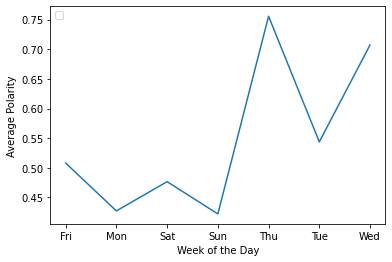

In [15]:
# pivot the table
by_week = pd.pivot_table(df, values='year', index=['label'], columns=['week'], aggfunc='count')
cols = ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']
by_week[cols] = by_week[cols] / by_week[cols].sum()
by_week = by_week.transpose()
by_week.index.name = None
by_week.columns.name = None

# plot the proportion of tweets with negative polarity across the whole week
sns.lineplot(data=by_week, x=by_week.index, y=0)
plt.title('')
plt.legend(loc=2)
plt.xlabel("Week of the Day")
plt.ylabel("Average Polarity")
plt.show()